In [1]:
%pip install -q tf-models-official==2.7.1 tensorflow-text==2.7.3


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Importing modules
 - `numpy` is imported due to setting random seed for pandas & sklearn so as to make it easier to reproduce results
 - `pandas` is imported for reading/loading are dataset which is in a tabular form (comma seperated value file format)
 - `matplotlib` is imported for creating graphs to visualize the training of our model. It's easier to see if it overfits or underfits
 - We are using `sklearn` for dividing our dataset into 3 parts, ie; training, validation and test sets
 - We are importing modules for `tensorflow` for our Deep Learning model
   - main tensorflow module for making, compiling and training the model.
   - `tensorflow-hub` for Bert preprocessor and text encoder
   - `tensorflow-text` as a workaround for a OP call error in `tensorflow-hub` possibly due to scoping issue or not being listed as a dependency
   - `tf-models-official` or official (as imported here) is used to get the AdamW optimizer for stochastic gradient descent based training of out model


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_text as tf_text
import tensorflow_hub as hub # for Bert Preprocessor and encoder
from official.nlp import optimization  # for AdamW optimizer

tf.get_logger().setLevel('ERROR')
%matplotlib inline

### Random Seed
Setting a seed manually here to keep things reproducible and consistent

In [3]:
seed = 13
tf.random.set_seed(seed)
np.random.seed(seed)


### Dataset handling
Read the file and load it as a `pandas.DataFrame` for quick processing

In [4]:
# load the dataset as a DataFrame
df = pd.read_csv("./deceptive-opinion.csv")

# Display 5 rows of tabular data, first 5 indices by default
df.head()


,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...
4,truthful,hyatt,positive,TripAdvisor,I asked for a high floor away from the elevato...


Describe gives some basic overview of the dataset by category/column/attribute, such as 
 - `count`/size (total number of rows by each category, gives a heads up incase there's missing attribute data), 
 - distinction (number of `unique` values for each attribute),
 - `freq`uency of the top most (or most frequent value in an attribute)

In [5]:
df.describe()


,deceptive,hotel,polarity,source,text
count,1600,1600,1600,1600,1600
unique,2,20,2,3,1596
top,truthful,conrad,positive,MTurk,The Omni was chosen for it's location whichwor...
freq,800,80,800,800,2


Just to confirm there are no null values, doesn't work with text/object attribute wherein, it could be `"null"`/`{}`/`[]` instead of `nil`

In [6]:
df.isnull().sum()


deceptive    0
hotel        0
polarity     0
source       0
text         0
dtype: int64

- We are dropping `hotel` and review `source` attributes so that our model learns to classify purely based on text and doesn't become brittle wherein it breaks if it encounters a new hotel name or source for the review fed to it. 

- By that we mean it doesn't end up overfitting on our dataset and be completely impractical for use.

- `polarity` is removed due it being data that isn't readily available in the text but rather an add-on value that has been provided in the dataset. We could make another classifier for polarity and then graft it's output with original text to use in our model but that's an unnecesarry complication.

In [7]:
new_df = df.drop(['hotel'], axis=1)
new_df = new_df.drop(['source'], axis=1)
new_df = new_df.drop(['polarity'], axis=1)
new_df.head()


,deceptive,text
0,truthful,We stayed for a one night getaway with family ...
1,truthful,Triple A rate with upgrade to view room was le...
2,truthful,This comes a little late as I'm finally catchi...
3,truthful,The Omni Chicago really delivers on all fronts...
4,truthful,I asked for a high floor away from the elevato...


We are making the text `lower`case since the classification is going to be case insensitive for ease, since people may capitalise things for various reasons other than grammatical as well as do it by mistake as is common on most user content on the internet.

We are also removing `URL`s from the reviews (if found) since they aren't relevant and could confuse the model as a feature for identifying as it as spam.

In [8]:
def text_cleaning(text):
    import re
    import string
    '''
    Make text lowercase, remove text in square brackets,remove links,remove special characters
    and remove words containing numbers.
    '''
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)  # remove URLs

    return text


In [9]:
new_df['text'] = new_df['text'].apply(text_cleaning)


Here we are mapping the `class`/category for truthful & deceptive to numeric form so that it's easier to measure loss, accuracy & confidence of our model.

In [10]:
def className(cName):
    if cName == 'truthful':
        return 0
    else:
        return 1


In [11]:
new_df['deceptive'] = new_df['deceptive'].apply(className)


Taking advantage of jupyter notebook's output truncating feature we are displaying first 5 and last 5 rows/tuples of data after our processing of the dataset. This was the last of dataset preprocessing.

In [12]:
new_df


,deceptive,text
0,0,we stayed for a one night getaway with family ...
1,0,triple a rate with upgrade to view room was le...
2,0,this comes a little late as i'm finally catchi...
3,0,the omni chicago really delivers on all fronts...
4,0,i asked for a high floor away from the elevato...
...,...,...
1595,1,problems started when i booked the intercontin...
1596,1,the amalfi hotel has a beautiful website and i...
1597,1,the intercontinental chicago magnificent mile ...
1598,1,"the palmer house hilton, while it looks good i..."


- we are converting our tabular dataset from `pandas.DataFrame` to `numpy.array` for feeding our model & division by test, validation, training
- we also seperate `classname` and `text` data as `y` and `x` `numpy.array` variables respectively from the tabular form it originally was

In [13]:
x = new_df.copy(deep=True)
y = x.pop('deceptive').to_numpy()
x = x['text'].to_numpy()


In [14]:
x # text data array


array(['we stayed for a one night getaway with family on a thursday. triple aaa rate of 173 was a steal. 7th floor room complete with 44in plasma tv bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) concierge was very helpful. you cannot beat this location... only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. food was very good so it was worth the wait. i would return in a heartbeat. a gem in chicago... \n',
       'triple a rate with upgrade to view room was less than $200 which also included breakfast vouchers. had a great view of river, lake, wrigley bldg. & tribune bldg. most major restaurants, shopping, sightseeing attractions within walking distance. large room with a very comfortable bed. \n',
       "this comes a little late as i'm finally catching up on my reviews from the past several months:) a dear friend

In [15]:
y # class array: classes for each text, both are indexed exactly so x[0] text corresponds with y[0]


array([0, 0, 0, ..., 1, 1, 1])

 ## Train, Test, Validation splits
  - Test set size: 160
  - Validation set size: 144
  - Train set size: 1296

In [16]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, random_state=seed, test_size=0.1, stratify=y)  # 1440, 160
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, random_state=seed, test_size=0.1, stratify=y_train)  # 1296, 144


In [17]:
print(type(x_train), type(y_train))


<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [18]:
training_set = pd.DataFrame({'text':x_train, 'class_label':y_train})
training_set.to_csv("training_set.csv", index=False)
validation_set = pd.DataFrame({'text':x_val, 'class_label':y_val})
validation_set.to_csv("validation_set.csv", index=False)
test_set = pd.DataFrame({'text':x_test, 'class_label':y_test})
test_set.to_csv("test_set.csv", index=False)

## Bert Encoder
We are using `small_Bert` with 4 hidden layers of 512 pooled output with 8 Attention heads
 - `L` = number of hidden layers, valid values being one of `[2, 4, 6, 8, 10, 12]`
 - `H` = pooled output size, valid values being one of `[128, 512, 768]`
 - `A` = number of Attention head, valid values being one of `[2, 4, 8, 12]`

In [19]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'


In [20]:
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')


BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


Here we are just looking at what and how `Bert` model we selected in prior cells are handling a test input

In [21]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
text_test = ['this is such an amazing hotel, got free breakfast!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :16]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :16]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :16]}')


Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3309 1010 2288 2489 6350  999  102    0
    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [22]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')


Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[-0.01987227  0.99802715 -0.01782324  0.11471643  0.7505131   0.8547754
  0.9769393  -0.96088856  0.1836034  -0.9910178   0.13961518 -0.953131  ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.11570202  0.15295406  0.56964415 ...  0.11270478  0.9187778
   0.33908707]
 [-0.68068695 -0.0180361   0.23996821 ...  0.0712609  -0.02126166
   0.9217441 ]
 [-0.6615662   0.96911967 -0.764838   ... -0.0338648  -0.0709905
   0.811811  ]
 ...
 [-0.60880786 -0.3976768  -0.40144145 ... -0.19483674 -0.05937178
   0.63956356]
 [-0.12815815  0.7059195   0.89031935 ...  0.09381335  1.2351756
   0.27097443]
 [ 0.2573583   1.1357542   0.12476863 ...  0.4488657   1.3416302
  -0.09689201]]


## Model building
This is our classifier model composed of `Bert` Encoder (includes it's own preprocessing as well) and 1 Dimensional Convolution layers (`tf.keras.layers.Conv1D`). 
 - We normalize the `pooled_output` from `Bert` before feeding it into the classifier
 - It is then reshaped from `(1, 512)` to `(16, 32)` for convolution layers
 - kernels(layer parameters) are initialised with `tf.keras.initializers.GlorotUniform` for use with `relu` (rectified ELU) activation
 - `tf.keras.layers.Dropout` for regularization. 
 - `tf.keras.layers.MaxPool` for using only the most pronounced features of encoded text
 - `tf.keras.layers.Flatten` is used to flattening the output from prior layers for the final perceptron
 - `tf.keras.layers.Dense` is the decision perceptron (Also referred to as `FullyConnected`) with sigmoid activation to get an output between `(0, 1)`

In [23]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(
        tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)  # [1, 128]
    encoder = hub.KerasLayer(tfhub_handle_encoder,
                             trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']  # [1, 512]
    initializer = tf.keras.initializers.GlorotUniform(seed=seed)
    net = tf.keras.layers.LayerNormalization(axis=1)(net)
    net = tf.keras.layers.Reshape((16, 32))(net)
    net = tf.keras.layers.Dropout(0.25)(net)
    net = tf.keras.layers.Conv1D(
        filters=128, kernel_size=9, kernel_initializer=initializer, padding='same', activation='relu')(net)
    net = tf.keras.layers.Dropout(0.25)(net)
    net = tf.keras.layers.MaxPool1D(pool_size=2)(net)
    net = tf.keras.layers.Conv1D(
        filters=128, kernel_size=7, kernel_initializer=initializer, padding='same', activation='relu')(net)
    net = tf.keras.layers.Dropout(0.25)(net)
    net = tf.keras.layers.MaxPool1D(pool_size=2)(net)
    net = tf.keras.layers.Flatten()(net)
    net = tf.keras.layers.Dense(
        1, activation='sigmoid', name='classifier')(net)
    return tf.keras.Model(text_input, net)


In [24]:
# Test code to see if model is able to process simple text string or not as intended
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
# This result here isn't accurate as model hasn't been trained yet
# It's just to check input/output of the model
print(bert_raw_result)


tf.Tensor([[0.4545582]], shape=(1, 1), dtype=float32)


In [25]:
tf.keras.utils.plot_model(classifier_model, show_shapes=True, show_dtype=True,
                          show_layer_names=True, expand_nested=True, dpi=128, show_layer_activations=True
                          )


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


 - We are using `tf.keras.losses.BinaryCrossentropy` for Binary cross-entropy loss for our binary classifier
 - We are using EarlyStopping callback to prevent overfitting.
 - `tf.metrics.BinaryAccuracy` is just a metric to evaluate model accuracy, binary means it expects output between `(0, 1)`

In [26]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metrics = [tf.metrics.BinaryAccuracy(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.TruePositives()]
# minimum delta is an aribitrary 3e-3, consider 2e-3 or higher values as well
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=1e-3, patience=3, verbose=0, mode='min', restore_best_weights=True),
    # tf.keras.callbacks.ModelCheckpoint("weights.hdf5", monitor='val_loss', save_best_only=True, save_freq='epoch'),
]


In [27]:
# Increased Epoch to 100 because EarlyStopping Callback will stop training once improvements stop
epochs = 100

# Here we are initialising the `AdamW` optimizer with hyperparameters
steps_per_epoch = x_train.size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

init_lr = 3e-5 # initial learning rate
optimizer = optimization.create_optimizer(
    init_lr=init_lr, num_train_steps=num_train_steps, num_warmup_steps=num_warmup_steps, optimizer_type='adamw')


In [28]:
# Compiles the model with the optimizer, loss function and metric to be used for evaluating progress
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


## Model Training
This is the training step for our model
`history` variable stores the per `epoch` results for training and validation dataset accuracy and loss
`step` = number of batches the the data is fed to the model for loss evaluation and parameter optimization
`epoch` = 1 complete run of all available `steps`, whole training data has been fed at the end of an epoch.

In [29]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=x_train, y=y_train, validation_data=(
    x_val, y_val), epochs=epochs, callbacks=callbacks)


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
41/41 [==============================] - 163s 4s/step - loss: 0.7276 - binary_accuracy: 0.5309 - false_negatives: 300.0000 - false_positives: 308.0000 - true_negatives: 340.0000 - true_positives: 348.0000 - val_loss: 0.6814 - val_binary_accuracy: 0.6111 - val_false_negatives: 19.0000 - val_false_positives: 37.0000 - val_true_negatives: 35.0000 - val_true_positives: 53.0000
Epoch 2/100
41/41 [==============================] - 137s 3s/step - loss: 0.7120 - binary_accuracy: 0.5494 - false_negatives: 262.0000 - false_positives: 322.0000 - true_negatives: 326.0000 - true_positives: 386.0000 - val_loss: 0.6807 - val_binary_accuracy: 0.6181 - val_false_negatives: 19.0000 - val_false_positives: 36.0000 - val_true_negatives: 36.0000 - val_true_positives: 53.0000
Epoch 3/100
41/41 [==============================] - 139s 3s/step - loss: 0.7272 - binary_accuracy: 0.5177 - false_negatives: 311.00

Epoch 22/100
41/41 [==============================] - 153s 4s/step - loss: 0.5659 - binary_accuracy: 0.7145 - false_negatives: 185.0000 - false_positives: 185.0000 - true_negatives: 463.0000 - true_positives: 463.0000 - val_loss: 0.5585 - val_binary_accuracy: 0.6944 - val_false_negatives: 5.0000 - val_false_positives: 39.0000 - val_true_negatives: 33.0000 - val_true_positives: 67.0000
Epoch 23/100
41/41 [==============================] - 158s 4s/step - loss: 0.5618 - binary_accuracy: 0.7238 - false_negatives: 166.0000 - false_positives: 192.0000 - true_negatives: 456.0000 - true_positives: 482.0000 - val_loss: 0.5291 - val_binary_accuracy: 0.7083 - val_false_negatives: 7.0000 - val_false_positives: 35.0000 - val_true_negatives: 37.0000 - val_true_positives: 65.0000
Epoch 24/100
41/41 [==============================] - 154s 4s/step - loss: 0.5213 - binary_accuracy: 0.7600 - false_negatives: 150.0000 - false_positives: 161.0000 - true_negatives: 487.0000 - true_positives: 498.0000 - val_

41/41 [==============================] - 160s 4s/step - loss: 0.1814 - binary_accuracy: 0.9336 - false_negatives: 44.0000 - false_positives: 42.0000 - true_negatives: 606.0000 - true_positives: 604.0000 - val_loss: 0.4718 - val_binary_accuracy: 0.8125 - val_false_negatives: 3.0000 - val_false_positives: 24.0000 - val_true_negatives: 48.0000 - val_true_positives: 69.0000
Epoch 44/100
41/41 [==============================] - 158s 4s/step - loss: 0.1701 - binary_accuracy: 0.9468 - false_negatives: 29.0000 - false_positives: 40.0000 - true_negatives: 608.0000 - true_positives: 619.0000 - val_loss: 0.3650 - val_binary_accuracy: 0.8403 - val_false_negatives: 5.0000 - val_false_positives: 18.0000 - val_true_negatives: 54.0000 - val_true_positives: 67.0000


In [30]:
history_dict = history.history
print(history_dict.keys())


dict_keys(['loss', 'binary_accuracy', 'false_negatives', 'false_positives', 'true_negatives', 'true_positives', 'val_loss', 'val_binary_accuracy', 'val_false_negatives', 'val_false_positives', 'val_true_negatives', 'val_true_positives'])


In [54]:
# a blind test for the model as it's never been evaluated against 
# or trained with the test set for a test of how well it's learnt to classify

loss, accuracy, fn, fp, tn, tp = classifier_model.evaluate(x_test, y_test)

print(f'Loss: {loss:.2}')
print(f'Accuracy: {accuracy:.2}')
print(f'True Positive Rate: {tp / (fn + tp):.2}')
print(f'True Negative Rate: {tn / (fp + tn):.2}')
recall = tp / (fn + tp)
precision = tp / (fp + tp)
print(f'F1 Score: {(2 * precision * recall) / (precision + recall):.2}')
print(f'Positive Predictive Value: {tp / (fp + tp):.2}')
print(f'Negative Predictive Value: {tn / (fn + tn):.2}')

5/5 [==============================] - 9s 2s/step - loss: 0.2874 - binary_accuracy: 0.9062 - false_negatives: 5.0000 - false_positives: 10.0000 - true_negatives: 70.0000 - true_positives: 75.0000
Loss: 0.29
Accuracy: 0.91
True Positive Rate: 0.94
True Negative Rate: 0.88
F1 Score: 0.91
Positive Predictive Value: 0.88
Negative Predictive Value: 0.93


## Training Graph
This graph plots the progress of the model's training based `accuracy` & `loss` for both training and validation datasets per `epoch`

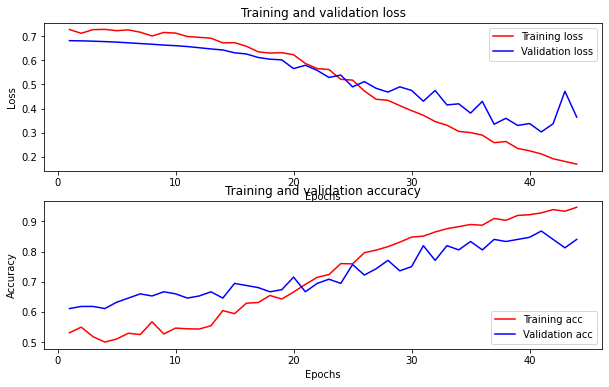

In [55]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


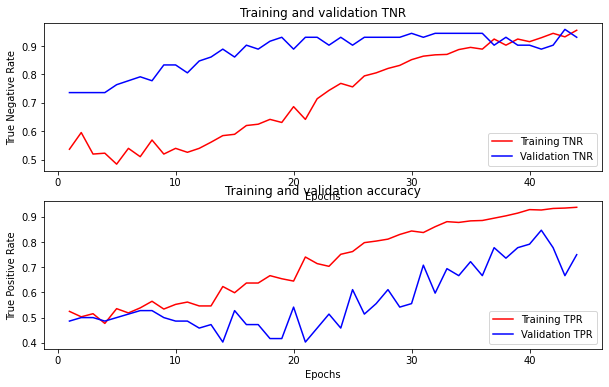

In [62]:
acc = np.array(history_dict['true_negatives']) / (np.array(history_dict['false_positives']) + np.array(history_dict['true_negatives']))
val_acc = np.array(history_dict['val_true_negatives']) / (np.array(history_dict['val_false_positives']) + np.array(history_dict['val_true_negatives']))
loss = np.array(history_dict['true_positives']) / (np.array(history_dict['false_negatives']) + np.array(history_dict['true_positives']))
val_loss = np.array(history_dict['val_true_positives']) / (np.array(history_dict['val_false_negatives']) + np.array(history_dict['val_true_positives']))

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training TNR')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation TNR')
plt.title('Training and validation TNR')
plt.xlabel('Epochs')
plt.ylabel('True Negative Rate')
plt.legend(loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training TPR')
plt.plot(epochs, val_acc, 'b', label='Validation TPR')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')


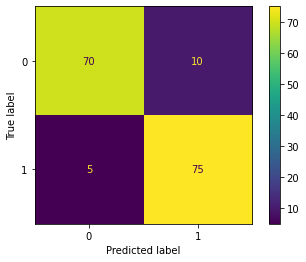

In [57]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

y_pred = classifier_model.predict(x_test)
# print(type(y_pred), y_pred)
y_pred_discrete = [0 if y <= 0.5 else 1 for y in y_pred]
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_discrete)
plt.show()

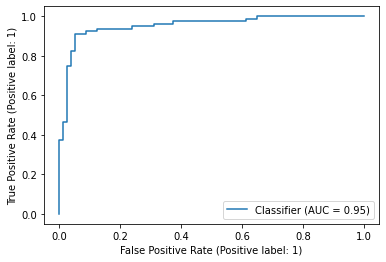

In [58]:
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()

In [59]:
classifier_model.save_weights("Weights.hdf5", overwrite=True)


In [60]:
classifier_model.save('Bert_Model', overwrite=True,
                      include_optimizer=True, save_format='tf')


In [61]:
!zip -r ./Bert_Model.zip ./Bert_Model


/usr/bin/sh: 1: zip: not found
